# Custom Training with Tensorflow 2
In this notebook we learn how to compute gradients with tensorflow 2 and how to use them for 
custom model training.

In [374]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, metrics, losses
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions

## 1. Computing gradients
- to compute gradients you need the tf.GradientTape()context

**First Derivative**

In [310]:
x = tf.constant(3.)

In [311]:
with tf.GradientTape() as tpe:
    tpe.watch(x)
    
    # function needs to be defined in the context
    y = tf.square(x)
    
dy_dx = tpe.gradient(y,x)  # dy/dx|3 = 2x|3 = 6
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


**Second Derivative**

In [312]:
with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        # function needs to be defined in the context
        y = tf.square(x)
        dy_dx = gg.gradient(y,x)  # dy/dx|3 = 2x|3 = 6
    dy_dx_2 = g.gradient(dy_dx, x) # d(2x)/dy = 2
print(dy_dx)
print(dy_dx_2)

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


**Gradient Descent**
Finding minimum of quadratic loss function using gradient descent. First, we update using the simple gradient descent rule $x_n = x - \alpha \frac{dy}{dx}$. Afterwards, we use an optimzer keras provides.

In [313]:
def loss(x):
    return (x-3)**2

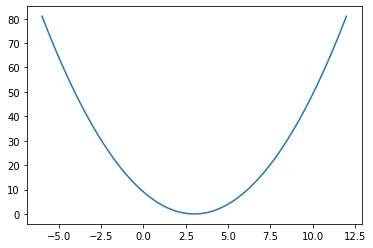

In [314]:
x = np.linspace(start=-6, stop=12, num=100)
plt.plot(x, loss(x))

In [315]:
x_start = tf.Variable(10.0)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)
learning_rate = 0.1
epochs = 100
for epoch in range(epochs):
    with tf.GradientTape() as g:
        g.watch(x_start)
        current_loss = loss(x_start)
        dloss_dx = g.gradient(current_loss, x_start)
    x_start.assign_add(-learning_rate*dloss_dx)
    if epoch % 20 == 0:
        print("Results during epoch: ", epoch)
        print("next x: ", x_start.numpy())
        print("current loss: ", current_loss.numpy())
        print("dloss_dx: ", dloss_dx.numpy())
        print("")

Results during epoch:  0
next x:  8.6
current loss:  49.0
dloss_dx:  14.0

Results during epoch:  20
next x:  3.0645635
current loss:  0.006513208
dloss_dx:  0.1614089

Results during epoch:  40
next x:  3.0007443
current loss:  8.654754e-07
dloss_dx:  0.0018606186

Results during epoch:  60
next x:  3.0000086
current loss:  1.1510792e-10
dloss_dx:  2.1457672e-05

Results during epoch:  80
next x:  3.0000005
current loss:  2.2737368e-13
dloss_dx:  9.536743e-07



In [316]:
x_start = tf.Variable(10.0)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)
learning_rate = 0.1
epochs = 100
for epoch in range(epochs):
    with tf.GradientTape() as g:
        g.watch(x_start)
        current_loss = loss(x_start)
        dloss_dx = g.gradient(current_loss, x_start)
    optimizer.apply_gradients(zip([dloss_dx],[x_start]))
    if epoch % 20 == 0:
        print("Results during epoch: ", epoch)
        print("next x: ", x_start.numpy())
        print("current loss: ", current_loss.numpy())
        print("dloss_dx: ", dloss_dx.numpy())
        print("")

Results during epoch:  0
next x:  9.683772
current loss:  49.0
dloss_dx:  14.0

Results during epoch:  20
next x:  7.259191
current loss:  18.925993
dloss_dx:  8.700803

Results during epoch:  40
next x:  5.589483
current loss:  7.1140885
dloss_dx:  5.33445

Results during epoch:  60
next x:  4.180467
current loss:  1.5444623
dloss_dx:  2.485528

Results during epoch:  80
next x:  3.2355545
current loss:  0.07062252
dloss_dx:  0.53149796



## 2. Linear Regresion

In [317]:
def my_function(x_arr, w0=2.3, w1=-3.7, noise=1.5):
    y = w1 * x_arr + w0 + np.random.normal(scale=noise, size=len(x_arr))
    return y

In [318]:
x = np.linspace(start=-5, stop=5, num=100)
y = my_function(x)

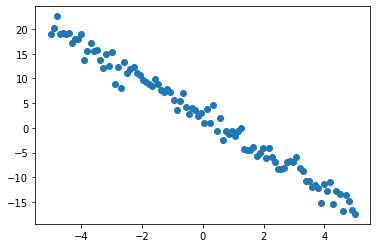

In [319]:
plt.plot(x,y, linestyle="None", marker="o")

In [320]:
x_data = tf.data.Dataset.from_tensor_slices(np.expand_dims(x,-1))
y_data = tf.data.Dataset.from_tensor_slices(y)
regression_data = tf.data.Dataset.zip((x_data,y_data))

In [321]:
input_dim = x_data.element_spec.shape[0]

### a) keras fit method

In [322]:
regressor = tf.keras.Sequential()
regressor.add(layers.Dense(1, input_shape=(1,))) # features, examples

In [323]:
regressor.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [324]:
regressor.compile(loss=losses.mean_squared_error)

In [325]:
regressor.fit(regression_data, epochs=100, verbose=0)

In [326]:
print(regressor.weights[0].numpy())
print(regressor.weights[1].numpy())

[[-3.65385]]
[2.1052525]


In [327]:
y_pred = regressor.predict(x_data)
y_pred[0]

array([20.374504], dtype=float32)

### b) custom training

In [328]:
class CustomTraining():
    
    def __init__(self, model, batch_size=32, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss=losses.MeanSquaredError()):
        self.model = model
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.loss = loss
    
    def train_epoch(self, X,y):
        loss_total = 0
        batches = 0
        for i, (X_batch, y_batch) in enumerate(zip(X,y)):
            with tf.GradientTape() as g:
                g.watch(self.model.weights)
                y_pred = self.model(X_batch)
                loss_epoch = self.loss(y_batch, y_pred)
                grads = g.gradient(loss_epoch, self.model.weights)
            loss_total = loss_total + loss_epoch.numpy()
            self.optimizer.apply_gradients(zip(grads,self.model.weights))
            batches = batches + i
        return loss_total / batches
        
    def fit(self, X, y, epochs=1, verbose=True):
        X_ = X.batch(self.batch_size)
        y_ = y.batch(self.batch_size)
        for epoch in range(epochs):
            loss = self.train_epoch(X_,y_)
            if verbose:
                if epoch % 10 == 0:
                    print("epoch: ", epoch)
                    print("loss: ", loss)
                    print("model: ", self.model.weights)
        
    

In [329]:
regressor = tf.keras.Sequential()
regressor.add(layers.Dense(1, input_shape=(1,))) # features, examples

In [330]:
custom = CustomTraining(model=regressor)

In [331]:
custom.train_epoch(x_data.batch(32), y_data.batch(32))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



32.814794858296715

In [332]:
custom.fit(x_data, y_data, epochs=100, verbose=True)

epoch:  0
loss:  18.331841309865315
model:  [<tf.Variable 'dense_22/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.426633]], dtype=float32)>, <tf.Variable 'dense_22/bias:0' shape=(1,) dtype=float32, numpy=array([0.15486497], dtype=float32)>]
epoch:  10
loss:  1.5717472632726033
model:  [<tf.Variable 'dense_22/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-3.6101685]], dtype=float32)>, <tf.Variable 'dense_22/bias:0' shape=(1,) dtype=float32, numpy=array([1.7979078], dtype=float32)>]
epoch:  20
loss:  1.2648730476697285
model:  [<tf.Variable 'dense_22/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-3.621345]], dtype=float32)>, <tf.Variable 'dense_22/bias:0' shape=(1,) dtype=float32, numpy=array([2.4192452], dtype=float32)>]
epoch:  30
loss:  1.2765143314997356
model:  [<tf.Variable 'dense_22/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-3.6411438]], dtype=float32)>, <tf.Variable 'dense_22/bias:0' shape=(1,) dtype=float32, numpy=array([2.459684], dtype=float32)>]

In [333]:
custom.model.weights

[<tf.Variable 'dense_22/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-3.6373248]], dtype=float32)>,
 <tf.Variable 'dense_22/bias:0' shape=(1,) dtype=float32, numpy=array([2.4639359], dtype=float32)>]

### 3. Binary Classification

In [339]:
X,y = make_classification(n_samples=600, n_features=2, n_redundant=0, random_state=42)

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [359]:
X_data = tf.data.Dataset.from_tensor_slices(X_train)
y_data = tf.data.Dataset.from_tensor_slices(y_train)
data = tf.data.Dataset.zip((X_data, y_data))

In [360]:
df_data = pd.DataFrame(data=X, columns=["x_1", "x_2"])
df_data["y"] = y

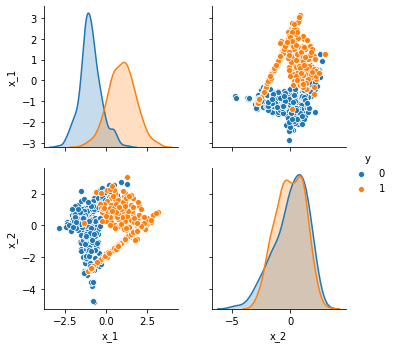

In [361]:
sns.pairplot(data=df_data, hue="y", vars=["x_1", "x_2"])

In [362]:
clf = tf.keras.Sequential()
clf.add(layers.Dense(1, input_shape=(2,)))
clf.add(layers.Activation(tf.nn.sigmoid))

In [363]:
clf.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1)                 3         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [366]:
custom_training = CustomTraining(model=clf, loss=losses.BinaryCrossentropy(from_logits=True))

In [368]:
custom_training.fit(X=X_data, y=y_data, epochs=100)

epoch:  0
loss:  0.09843276739120484
model:  [<tf.Variable 'dense_25/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.5223336 ],
       [0.06824602]], dtype=float32)>, <tf.Variable 'dense_25/bias:0' shape=(1,) dtype=float32, numpy=array([-0.21927133], dtype=float32)>]
epoch:  10
loss:  0.07840925199644906
model:  [<tf.Variable 'dense_25/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 7.1053376],
       [-1.1755619]], dtype=float32)>, <tf.Variable 'dense_25/bias:0' shape=(1,) dtype=float32, numpy=array([-0.7427837], dtype=float32)>]
epoch:  20
loss:  0.07812236263638452
model:  [<tf.Variable 'dense_25/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[10.088914 ],
       [-1.6738311]], dtype=float32)>, <tf.Variable 'dense_25/bias:0' shape=(1,) dtype=float32, numpy=array([-1.1074785], dtype=float32)>]
epoch:  30
loss:  0.07805440709704445
model:  [<tf.Variable 'dense_25/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[11.779388 ],
       [-1.9363257]], dtype=float32)>, 

In [369]:
clf = custom_training.model

In [371]:
clf.weights

[<tf.Variable 'dense_25/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[18.352562 ],
        [-2.9228141]], dtype=float32)>,
 <tf.Variable 'dense_25/bias:0' shape=(1,) dtype=float32, numpy=array([-2.2224464], dtype=float32)>]

In [373]:
clf.predict(X_test)[:3]

array([[2.7560134e-04],
       [1.6284206e-10],
       [8.4686142e-01]], dtype=float32)

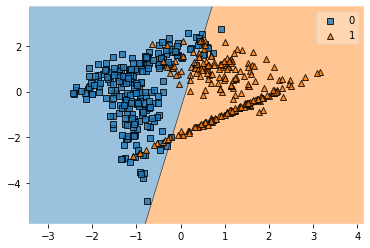

In [375]:
plot_decision_regions(X_train, y_train, clf=clf)

In [376]:
clf = tf.keras.Sequential()
clf.add(layers.Dense(8, input_shape=(2,)))
clf.add(layers.Activation(tf.nn.sigmoid))
clf.add(layers.Dense(1, input_shape=(2,)))
clf.add(layers.Activation(tf.nn.sigmoid))

In [377]:
custom_training = CustomTraining(model=clf, loss=losses.BinaryCrossentropy(from_logits=True))
custom_training.fit(X=X_data, y=y_data, epochs=100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch:  0
loss:  0.08698532183965048
model:  [<tf.Variable 'dense_26/kernel:0' shape=(2, 8) dtype=float32, numpy=
array([[ 0.5026407 , -1.4141338 , -1.6832645 ,  1.4652658 , -2.0108504 ,
         1.4024752 ,  1.4578724 ,  1.4922479 ],
       [ 0.03992398,  0.6396711 ,  0.55807906, -0.3539572 ,  0.4941697 ,
        -0.22571975, -0.3792092 , -0.43649372]], dtype=float32)>, <tf.Variable 'dense_26/bias:0' shape=(8,) dtype=float32, numpy=
array([-0.1852021 ,  0.06175438,  0.09182926, -0.20793822,  0.11821315

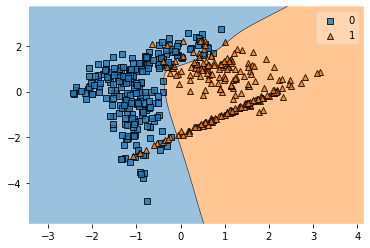

In [378]:
plot_decision_regions(X_train, y_train, clf=clf)